# Multi-Dimensional Hill Climbing with Compression

## 🎯 Goal

Generalize 1D compression to **N-dimensional** space by treating each axis independently.

---

## 📋 Strategy

**Independent Axis Compression for N-D:**
- Starting point: `(x₀, x₁, ..., x_{n-1})` where n = dim
- When stuck at local minimum:
  - For each dimension i (0 to n-1):
    - Fix all other dimensions, vary dimension i
    - Detect basin along dimension i
    - Compress if basin found
  - Try multiple restart candidates from all dimension ends
  - Pick best restart point
- Continue hill climbing in compressed space

---

## 🔧 Implementation

### Cell 1: Base Classes (1D building blocks)
- `SigmoidWarping`: 1D compression using sigmoid
- `MetadataCompressionOriginalSpace`: Manages compressions in original X-space
- `detect_compression_basin`: Bidirectional basin detection with 3 rules
- `merge_overlapping_compressions`: Handles overlaps

### Cell 2: Multi-D Extension
- `CompressionManagerND`: Manages compressions for all dimensions
- `hill_climb_with_compression_nd`: Main N-D algorithm with `dim` parameter
- `hill_climb_simple_nd`: Baseline without compression

### Cell 3: Test & Comparison
- Simple N-D test functions
- Success/fail comparison (no visualization for high-D)
- Statistics: success rate, steps, convergence

---

## 📊 How to Use

```python
# Define N-D fitness function
def fitness_nd(point):
    # point is tuple/list of length dim
    return sum((p - 10)**2 for p in point)  # Example: sphere function

# Run with compression
traj, cm = hill_climb_with_compression_nd(
    fitness_nd,
    start_point=(0, 0, 0),  # 3D example
    dim=3,
    max_iterations=10,
    basin_max_search=30
)

# Compare with baseline
traj_baseline = hill_climb_simple_nd(
    fitness_nd,
    start_point=(0, 0, 0),
    dim=3,
    max_steps=1000
)
```

---

## 📚 Reference

- **1D version**: `framework.ipynb` (working perfectly)
- **2D version**: Check backup files for 2D-specific visualizations

In [16]:
import numpy as np
from scipy.special import expit as sigmoid, logit
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Optional
from dataclasses import dataclass

print("✅ Imports loaded!")
print("📍 Focus: Hill climbing with adaptive compression")

# ===============================
# Warping
# ===============================
class SigmoidWarping:
    """Compress integer region to length-1 interval."""
    def __init__(self, node_index, length, steepness=5.0):
        self.node_start = int(node_index)
        self.length = int(length)
        assert self.length >= 2, "Compression length must be >= 2."
        self.node_end = self.node_start + self.length
        self.steepness = float(steepness)
        self.shift = self.length - 1  # how much right side is pulled left

    def forward(self, node):
        """X → Z"""
        node = np.atleast_1d(node).astype(float)
        position = np.zeros(len(node), dtype=float)
        for i, n in enumerate(node):
            if n < self.node_start:
                position[i] = float(n)
            elif n > self.node_end:
                position[i] = float(n) - self.shift
            else:
                if n == self.node_start:
                    position[i] = float(self.node_start)
                elif n == self.node_end:
                    position[i] = float(self.node_start + 1)
                else:
                    t = (n - self.node_start) / self.length
                    x = self.steepness * (t - 0.5)
                    s = sigmoid(x)
                    position[i] = self.node_start + s
        return position[0] if len(node) == 1 else position

    def inverse(self, position):
        """Z → X"""
        position = np.atleast_1d(position).astype(float)
        node = np.zeros(len(position), dtype=int)
        for i, pos in enumerate(position):
            if pos < self.node_start:
                node[i] = int(np.floor(pos))
            elif pos >= self.node_start + 1.0:
                node[i] = int(np.ceil(pos + self.shift))
            else:
                s = np.clip(pos - self.node_start, 0.0, 1.0)
                if s <= 0.01:
                    node[i] = self.node_start
                elif s >= 0.99:
                    node[i] = self.node_end
                else:
                    x = logit(s)
                    t = x / self.steepness + 0.5
                    node_f = self.node_start + t * self.length
                    node[i] = int(round(node_f))
        return node[0] if len(position) == 1 else node

class MetadataCompressionOriginalSpace:
    """Metadata ALWAYS in ORIGINAL X-space."""
    def __init__(self, compressions_x_space=None, steepness=5.0):
        self.metadata_x = sorted(compressions_x_space or [], key=lambda x: x[0])
        self.steepness = float(steepness)
        self.warpings = []
        self.z_positions = []
        if self.metadata_x:
            print(f"\n{'='*80}")
            print(f"📦 METADATA (Original X-space): {self.metadata_x}")
            print(f"{'='*80}")
            self._build_warpings()
            print(f"✅ Built {len(self.warpings)} compressions")
            print(f"{'='*80}\n")

    def _build_warpings(self):
        self.warpings = []
        self.z_positions = []
        cumulative_shift = 0
        for i, (x_start, x_length) in enumerate(self.metadata_x):
            assert x_length >= 2, "Each compression length must be >= 2."
            x_end = x_start + x_length
            z_start = x_start - cumulative_shift
            z_length = x_length
            print(f"  Compression #{i+1}:")
            print(f"    Original X[{x_start}, {x_end}] → Z[{z_start}, {z_start + z_length}]")
            print(f"    Saves {z_length - 1} nodes")
            warping = SigmoidWarping(z_start, z_length, self.steepness)
            self.warpings.append(warping)
            self.z_positions.append((z_start, z_length))
            cumulative_shift += (z_length - 1)

    def forward(self, node):
        """X → Z"""
        position = node
        for warping in self.warpings:
            position = warping.forward(position)
        return position

    def inverse(self, position):
        """Z → X"""
        node = position
        for warping in reversed(self.warpings):
            node = warping.inverse(node)
        return node


# ===============================
# Bidirectional Basin Detector (FIXED)
# ===============================
def detect_compression_basin(fitness_func, local_min_x, max_search=100):
    """
    Bidirectional basin detection with CORRECT priority logic:

    Rule 1: if current_fit == local_fit, continue to search (record farthest point)
    Rule 2: if current_fit > local_fit, keep searching within limited length
    Rule 3: if current_fit < local_fit, STOP (exited basin) - USE THIS EXIT POINT

    PRIORITY: Use Rule 3 exit point if found, otherwise use farthest equal-fitness point from Rule 1.

    Search both LEFT and RIGHT from local_min_x.

    Returns:
    --------
    (start_x, length) or None if no compression needed
    """
    local_min_fitness = fitness_func(local_min_x)

    print(f"  🔍 Detecting basin from local min: x={local_min_x}, fitness={local_min_fitness:.2f}")

    # LEFT search
    left_boundary = local_min_x
    farthest_left_equal = local_min_x
    found_left_equal = False
    found_left_exit = False

    for i in range(1, max_search + 1):
        current_x = local_min_x - i
        current_fitness = fitness_func(current_x)

        if abs(current_fitness - local_min_fitness) < 1e-9:  # Rule 1
            farthest_left_equal = current_x
            found_left_equal = True
            print(f"    LEFT: x={current_x}, fitness={current_fitness:.2f} == {local_min_fitness:.2f} (continue)")
        elif current_fitness > local_min_fitness:  # Rule 2
            print(f"    LEFT: x={current_x}, fitness={current_fitness:.2f} > {local_min_fitness:.2f} (plateau/hill)")
        else:  # Rule 3
            print(f"    LEFT: x={current_x}, fitness={current_fitness:.2f} < {local_min_fitness:.2f} (EXIT!)")
            left_boundary = current_x + 1
            found_left_exit = True
            break
    else:
        left_boundary = local_min_x - max_search

    # Priority: Use Rule 3 exit point if found, otherwise farthest equal-fitness
    if found_left_exit:
        print(f"    ✅ LEFT: Using Rule 3 exit boundary: x={left_boundary}")
    elif found_left_equal:
        left_boundary = farthest_left_equal
        print(f"    ✅ LEFT: Using farthest equal-fitness point (no exit found): x={left_boundary}")

    # RIGHT search
    right_boundary = local_min_x
    farthest_right_equal = local_min_x
    found_right_equal = False
    found_right_exit = False

    for i in range(1, max_search + 1):
        current_x = local_min_x + i
        current_fitness = fitness_func(current_x)

        if abs(current_fitness - local_min_fitness) < 1e-9:  # Rule 1
            farthest_right_equal = current_x
            found_right_equal = True
            print(f"    RIGHT: x={current_x}, fitness={current_fitness:.2f} == {local_min_fitness:.2f} (continue)")
        elif current_fitness > local_min_fitness:  # Rule 2
            print(f"    RIGHT: x={current_x}, fitness={current_fitness:.2f} > {local_min_fitness:.2f} (plateau/hill)")
        else:  # Rule 3
            print(f"    RIGHT: x={current_x}, fitness={current_fitness:.2f} < {local_min_fitness:.2f} (EXIT!)")
            right_boundary = current_x - 1
            found_right_exit = True
            break
    else:
        right_boundary = local_min_x + max_search

    # Priority: Use Rule 3 exit point if found, otherwise farthest equal-fitness
    if found_right_exit:
        print(f"    ✅ RIGHT: Using Rule 3 exit boundary: x={right_boundary}")
    elif found_right_equal:
        right_boundary = farthest_right_equal
        print(f"    ✅ RIGHT: Using farthest equal-fitness point (no exit found): x={right_boundary}")

    basin_length = right_boundary - left_boundary + 1

    if basin_length < 2:
        print(f"  ⚠️ No compression: basin too small (length={basin_length})")
        return None

    if not (found_left_equal or found_right_equal or found_left_exit or found_right_exit):
        print(f"  ⚠️ No compression: only Rule 2 exists")
        return None

    print(f"  ✅ Basin detected: X[{left_boundary}, {right_boundary}], length={basin_length}")
    return (left_boundary, basin_length)

print("✅ Bidirectional basin detection defined (WITH PRIORITY FIX!)")

# ===============================
# Metadata Overlap Handler
# ===============================
def merge_overlapping_compressions(compressions):
    """
    Handle overlapping compressions in ORIGINAL X-space.
    """
    if not compressions:
        return []

    sorted_comps = sorted(compressions, key=lambda x: x[0])
    merged = []

    for start, length in sorted_comps:
        end = start + length - 1

        if not merged:
            merged.append((start, length))
            continue

        last_start, last_length = merged[-1]
        last_end = last_start + last_length - 1

        if start <= last_end + 1:
            new_start = min(start, last_start)
            new_end = max(end, last_end)
            new_length = new_end - new_start + 1
            merged[-1] = (new_start, new_length)
            print(f"  🔄 Merged: ({start},{length}) + ({last_start},{last_length}) → ({new_start},{new_length})")
        else:
            merged.append((start, length))

    return merged

✅ Imports loaded!
📍 Focus: Hill climbing with adaptive compression
✅ Bidirectional basin detection defined (WITH PRIORITY FIX!)


In [17]:
# ===============================
# Multi-D Compression Manager
# ===============================
class CompressionManagerND:
    """
    Manage 1D compressions along each dimension in N-D space.
    
    For each dimension i, we maintain compressions indexed by
    the fixed values of all other dimensions.
    
    Example for 3D:
    - dim_compressions[0][(y_val, z_val)] = list of (x_start, length) compressions
    - dim_compressions[1][(x_val, z_val)] = list of (y_start, length) compressions
    - dim_compressions[2][(x_val, y_val)] = list of (z_start, length) compressions
    """
    def __init__(self, dim, steepness=5.0):
        self.dim = dim
        self.steepness = float(steepness)
        # dim_compressions[i] = dict mapping fixed_coords → list of compressions
        self.dim_compressions = [{} for _ in range(dim)]
        # dim_systems[i] = dict mapping fixed_coords → MetadataCompressionOriginalSpace
        self.dim_systems = [{} for _ in range(dim)]
    
    def update_dimension(self, vary_dim, fixed_coords, basin):
        """
        Add compression along dimension vary_dim.
        
        Parameters:
        -----------
        vary_dim : int
            Which dimension to compress (0 to dim-1)
        fixed_coords : tuple
            Values of all other dimensions (length = dim-1)
        basin : tuple (start, length) or None
            Basin detected along vary_dim
        """
        if basin is None:
            return
        
        # Get existing compressions for this slice
        comps = self.dim_compressions[vary_dim].get(fixed_coords, [])
        comps.append(basin)
        comps = merge_overlapping_compressions(comps)
        
        # Store updated compressions
        self.dim_compressions[vary_dim][fixed_coords] = comps
        self.dim_systems[vary_dim][fixed_coords] = MetadataCompressionOriginalSpace(
            compressions_x_space=comps,
            steepness=self.steepness
        )
    
    def get_system(self, vary_dim, fixed_coords):
        """Get compression system for a specific dimension slice."""
        return self.dim_systems[vary_dim].get(fixed_coords, None)


def detect_basin_along_dimension(fitness_func_nd, point, vary_dim, max_search=100):
    """
    Detect basin along one dimension while fixing all others.
    
    Parameters:
    -----------
    fitness_func_nd : callable
        N-D fitness function taking tuple/list of coordinates
    point : tuple/list
        Current point in N-D space
    vary_dim : int
        Which dimension to vary (0 to dim-1)
    max_search : int
        Maximum search distance
    
    Returns:
    --------
    (start, length) or None
    """
    def f1d(val):
        # Create point with val at vary_dim, fixed elsewhere
        new_point = list(point)
        new_point[vary_dim] = int(val)
        return fitness_func_nd(tuple(new_point))
    
    return detect_compression_basin(f1d, local_min_x=int(point[vary_dim]), max_search=max_search)


# ===============================
# N-D Hill-climb with Compression
# ===============================
def hill_climb_with_compression_nd(
    fitness_func_nd,
    start_point,
    dim,
    max_iterations=10,
    basin_max_search=100,
    global_min_threshold=1e-6
):
    """
    N-D hill climbing with axis-aligned 1D compressions.
    
    Parameters:
    -----------
    fitness_func_nd : callable
        Fitness function taking tuple/list of dim coordinates
    start_point : tuple/list
        Starting point (length = dim)
    dim : int
        Number of dimensions
    max_iterations : int
        Maximum compression iterations
    basin_max_search : int
        Maximum basin search distance per dimension
    global_min_threshold : float
        Threshold for global minimum detection
    
    Returns:
    --------
    traj : list of (point, fitness, used_compression)
    cm : CompressionManagerND
    """
    traj = []
    cm = CompressionManagerND(dim, steepness=5.0)

    # Initialize point
    point = tuple(int(x) for x in start_point)
    f = fitness_func_nd(point)
    traj.append((point, f, False))

    print(f"\n🚀 {dim}D hill climbing start at {point}, f={f:.4f}\n")

    for it in range(max_iterations):
        print("="*80)
        print(f"🔄 Iteration {it+1}/{max_iterations}")
        print("="*80)

        step_count = 0
        while True:
            # ----- Propose neighbors in all 2*dim directions -----
            candidates = []
            
            for d in range(dim):
                # Get compression system for this dimension
                fixed_coords = tuple(point[i] for i in range(dim) if i != d)
                comp_sys = cm.get_system(d, fixed_coords)
                
                if comp_sys is not None:
                    # Use compressed space
                    z = comp_sys.forward(point[d])
                    neighbor_minus = comp_sys.inverse(z - 1)
                    neighbor_plus = comp_sys.inverse(z + 1)
                else:
                    # No compression, use regular neighbors
                    neighbor_minus = point[d] - 1
                    neighbor_plus = point[d] + 1
                
                # Create neighbor points
                point_minus = list(point)
                point_minus[d] = neighbor_minus
                candidates.append((tuple(point_minus), fitness_func_nd(tuple(point_minus))))
                
                point_plus = list(point)
                point_plus[d] = neighbor_plus
                candidates.append((tuple(point_plus), fitness_func_nd(tuple(point_plus))))
            
            # Pick best neighbor (steepest descent)
            best_point, best_f = point, f
            for cand_point, cand_f in candidates:
                if cand_f < best_f:
                    best_point, best_f = cand_point, cand_f

            if best_f < f:
                point, f = best_point, best_f
                used_comp = any(cm.get_system(d, tuple(point[i] for i in range(dim) if i != d)) is not None 
                              for d in range(dim))
                traj.append((point, f, used_comp))
                step_count += 1
            else:
                print(f"  📍 Climbed {step_count} steps, now at {point}, f={f:.6g}")
                break

        # Check convergence / global min
        if abs(f) < global_min_threshold:
            print("\n🎉 SUCCESS: reached near-global minimum")
            break

        print(f"\n⚠️ STUCK at local minimum {point}, f={f:.6g}")
        print(f"  🔍 Detecting basins along all {dim} dimensions...")

        # ----- Detect basins along each dimension -----
        basins = {}  # dimension -> (start, length)
        for d in range(dim):
            basin = detect_basin_along_dimension(fitness_func_nd, point, d, max_search=basin_max_search)
            if basin:
                fixed_coords = tuple(point[i] for i in range(dim) if i != d)
                print(f"  ✅ Dim {d} basin: {basin}")
                cm.update_dimension(d, fixed_coords, basin)
                basins[d] = basin

        if not basins:
            print("\n  ⚠️ No compressible basin found in any dimension. Stopping.")
            break

        # ----- Choose restart point after compression -----
        # Try both ends of each detected basin
        restart_candidates = []
        
        for d, (b_start, b_len) in basins.items():
            b_end = b_start + b_len - 1
            
            # Try left end (start - 1)
            restart_point = list(point)
            restart_point[d] = b_start - 1
            restart_candidates.append((tuple(restart_point), fitness_func_nd(tuple(restart_point))))
            
            # Try right end (end + 1)
            restart_point = list(point)
            restart_point[d] = b_end + 1
            restart_candidates.append((tuple(restart_point), fitness_func_nd(tuple(restart_point))))

        # Pick best restart candidate
        if restart_candidates:
            restart_point, restart_f = min(restart_candidates, key=lambda t: t[1])
            print(f"\n  ➡️ Restarting from {restart_point}, f={restart_f:.4f}")
            point, f = restart_point, restart_f
            traj.append((point, f, True))
        else:
            print("\n  ⚠️ No valid restart candidate. Stopping.")
            break

    print("\n" + "="*80)
    print(f"🏁 FINAL {dim}D RESULTS")
    print("="*80)
    print(f"  Final position: {point}")
    print(f"  Final fitness: {f:.6g}")
    print(f"  Total steps:   {len(traj)}")
    total_compressions = sum(len(cm.dim_compressions[d]) for d in range(dim))
    print(f"  Total compressions: {total_compressions}")
    print("="*80 + "\n")

    return traj, cm


# ===============================
# Baseline: N-D Hill Climb WITHOUT Compression
# ===============================
def hill_climb_simple_nd(
    fitness_func_nd,
    start_point,
    dim,
    max_steps=2000
):
    """
    Simple N-D hill climbing WITHOUT compression (for comparison).
    
    Returns:
    --------
    traj : list of (point, fitness)
    """
    point = tuple(int(x) for x in start_point)
    f = fitness_func_nd(point)
    traj = [(point, f)]

    for _ in range(max_steps):
        # Try 2*dim neighbors (±1 in each dimension)
        candidates = []
        for d in range(dim):
            # -1 in dimension d
            neighbor = list(point)
            neighbor[d] -= 1
            candidates.append((tuple(neighbor), fitness_func_nd(tuple(neighbor))))
            
            # +1 in dimension d
            neighbor = list(point)
            neighbor[d] += 1
            candidates.append((tuple(neighbor), fitness_func_nd(tuple(neighbor))))

        # Pick best
        best_point, best_f = point, f
        for cand_point, cand_f in candidates:
            if cand_f < best_f:
                best_point, best_f = cand_point, cand_f

        if best_f < f:
            point, f = best_point, best_f
            traj.append((point, f))
        else:
            break  # Stuck at local minimum

    return traj


print("✅ N-D Hill climbing with compression defined!")
print("✅ Baseline N-D hill climbing (no compression) defined!")
print("\n" + "="*80)
print("📋 USAGE:")
print("="*80)
print("""
# Run with compression:
traj, cm = hill_climb_with_compression_nd(
    fitness_func=my_func,
    start_point=(0, 0, 0),  # or any dim
    dim=3,                   # specify dimensionality
    max_iterations=10,
    basin_max_search=30
)

# Run baseline (no compression):
traj_baseline = hill_climb_simple_nd(
    fitness_func=my_func,
    start_point=(0, 0, 0),
    dim=3,
    max_steps=1000
)

# Compare results
print(f"Compression: {len(traj)} steps, f={traj[-1][1]:.4f}")
print(f"Baseline: {len(traj_baseline)} steps, f={traj_baseline[-1][1]:.4f}")
""")


✅ N-D Hill climbing with compression defined!
✅ Baseline N-D hill climbing (no compression) defined!

📋 USAGE:

# Run with compression:
traj, cm = hill_climb_with_compression_nd(
    fitness_func=my_func,
    start_point=(0, 0, 0),  # or any dim
    dim=3,                   # specify dimensionality
    max_iterations=10,
    basin_max_search=30
)

# Run baseline (no compression):
traj_baseline = hill_climb_simple_nd(
    fitness_func=my_func,
    start_point=(0, 0, 0),
    dim=3,
    max_steps=1000
)

# Compare results
print(f"Compression: {len(traj)} steps, f={traj[-1][1]:.4f}")
print(f"Baseline: {len(traj_baseline)} steps, f={traj_baseline[-1][1]:.4f}")



In [18]:
import numpy as np

# ===============================
# Multi-D Test Functions
# ===============================

def sphere_function(point, optimal=(10,)*10):
    """
    Sphere function: sum of (x_i - opt_i)^2
    Global minimum at optimal with f=0
    """
    return sum((p - o)**2 for p, o in zip(point, optimal))


def rosenbrock_function(point):
    """
    Rosenbrock function (valley-shaped)
    Global minimum at (1, 1, ..., 1) with f=0
    """
    total = 0
    for i in range(len(point) - 1):
        total += 100 * (point[i+1] - point[i]**2)**2 + (1 - point[i])**2
    return total


def rastrigin_function(point):
    """
    Rastrigin function (many local minima)
    Global minimum at (0, 0, ..., 0) with f=0
    """
    A = 10
    n = len(point)
    return A * n + sum(p**2 - A * np.cos(2 * np.pi * p) for p in point)


print("✅ Test functions defined:")
print("  - sphere_function: Simple quadratic")
print("  - rosenbrock_function: Valley-shaped, harder")
print("  - rastrigin_function: Many local minima, very hard")


✅ Test functions defined:
  - sphere_function: Simple quadratic
  - rosenbrock_function: Valley-shaped, harder
  - rastrigin_function: Many local minima, very hard


In [19]:
# ===============================
# Comparison Test: Compression vs Baseline
# ===============================

def run_comparison(fitness_func, dim, start_point, optimal_val=0.0, threshold=1e-3,
                   max_iterations=10, basin_max_search=30, max_steps_baseline=1000):
    """
    Compare hill climbing with compression vs without.
    
    Returns:
    --------
    dict with keys:
        - success_comp: bool
        - success_baseline: bool
        - steps_comp: int
        - steps_baseline: int
        - final_f_comp: float
        - final_f_baseline: float
    """
    # Run with compression
    traj_comp, cm = hill_climb_with_compression_nd(
        fitness_func,
        start_point=start_point,
        dim=dim,
        max_iterations=max_iterations,
        basin_max_search=basin_max_search,
        global_min_threshold=threshold
    )
    
    final_f_comp = traj_comp[-1][1]
    success_comp = abs(final_f_comp - optimal_val) < threshold
    
    # Run without compression
    traj_baseline = hill_climb_simple_nd(
        fitness_func,
        start_point=start_point,
        dim=dim,
        max_steps=max_steps_baseline
    )
    
    final_f_baseline = traj_baseline[-1][1]
    success_baseline = abs(final_f_baseline - optimal_val) < threshold
    
    return {
        'success_comp': success_comp,
        'success_baseline': success_baseline,
        'steps_comp': len(traj_comp),
        'steps_baseline': len(traj_baseline),
        'final_f_comp': final_f_comp,
        'final_f_baseline': final_f_baseline,
    }


print("✅ Comparison function defined")
print("\nReady to run tests. Example usage:")
print("""
# Test 3D sphere function
result = run_comparison(
    sphere_function,
    dim=3,
    start_point=(0, 0, 0),
    optimal_val=0.0,
    threshold=1.0
)
print(f"Compression success: {result['success_comp']}")
print(f"Baseline success: {result['success_baseline']}")
""")


✅ Comparison function defined

Ready to run tests. Example usage:

# Test 3D sphere function
result = run_comparison(
    sphere_function,
    dim=3,
    start_point=(0, 0, 0),
    optimal_val=0.0,
    threshold=1.0
)
print(f"Compression success: {result['success_comp']}")
print(f"Baseline success: {result['success_baseline']}")



In [20]:
# ===============================
# Run Simple Test: 3D Sphere Function
# ===============================

print("="*80)
print("🧪 TEST: 3D Sphere Function")
print("="*80)
print("\nFunction: f(x,y,z) = (x-10)² + (y-10)² + (z-10)²")
print("Global minimum: (10, 10, 10) with f=0")
print("Start: (0, 0, 0)")
print("\n" + "="*80)

# Define 3D sphere
def sphere_3d(point):
    return sum((p - 10)**2 for p in point)

# Run test with less verbose output
print("\n🔹 WITH COMPRESSION:")
print("-"*80)
traj_comp, cm = hill_climb_with_compression_nd(
    sphere_3d,
    start_point=(0, 0, 0),
    dim=3,
    max_iterations=5,
    basin_max_search=30,
    global_min_threshold=1.0
)

print("\n🔹 WITHOUT COMPRESSION (BASELINE):")
print("-"*80)
traj_baseline = hill_climb_simple_nd(
    sphere_3d,
    start_point=(0, 0, 0),
    dim=3,
    max_steps=1000
)

print(f"\nBaseline steps: {len(traj_baseline)}")
print(f"Final position: {traj_baseline[-1][0]}")
print(f"Final fitness: {traj_baseline[-1][1]:.6g}")

# Compare
print("\n" + "="*80)
print("📊 COMPARISON")
print("="*80)
print(f"{'Metric':<30} {'With Compression':<20} {'Baseline'}")
print("-"*80)
print(f"{'Steps taken':<30} {len(traj_comp):<20} {len(traj_baseline)}")
print(f"{'Final fitness':<30} {traj_comp[-1][1]:<20.4f} {traj_baseline[-1][1]:.4f}")
print(f"{'Success (f < 1.0)':<30} {traj_comp[-1][1] < 1.0!s:<20} {traj_baseline[-1][1] < 1.0}")
print(f"{'Final position':<30} {str(traj_comp[-1][0]):<20} {str(traj_baseline[-1][0])}")

if traj_comp[-1][1] < traj_baseline[-1][1]:
    print("\n✅ Compression found BETTER solution!")
elif traj_comp[-1][1] < 1.0 and traj_baseline[-1][1] >= 1.0:
    print("\n✅ Compression SUCCESS, baseline FAILED!")
else:
    print("\n⚠️ Both methods performed similarly")

print("="*80)


🧪 TEST: 3D Sphere Function

Function: f(x,y,z) = (x-10)² + (y-10)² + (z-10)²
Global minimum: (10, 10, 10) with f=0
Start: (0, 0, 0)


🔹 WITH COMPRESSION:
--------------------------------------------------------------------------------

🚀 3D hill climbing start at (0, 0, 0), f=300.0000

🔄 Iteration 1/5
  📍 Climbed 30 steps, now at (10, 10, 10), f=0

🎉 SUCCESS: reached near-global minimum

🏁 FINAL 3D RESULTS
  Final position: (10, 10, 10)
  Final fitness: 0
  Total steps:   31
  Total compressions: 0


🔹 WITHOUT COMPRESSION (BASELINE):
--------------------------------------------------------------------------------

Baseline steps: 31
Final position: (10, 10, 10)
Final fitness: 0

📊 COMPARISON
Metric                         With Compression     Baseline
--------------------------------------------------------------------------------
Steps taken                    31                   31
Final fitness                  0.0000               0.0000
Success (f < 1.0)              True        

Test function ready. Global min is at (0,0) with f=0.
Start: (35, -10), f=1.0200

🚀 2D hill climbing start at (35, -10), f=1.0200

🔄 Iteration 1/20
  📍 Climbed 1 steps, now at (36, -10), f=1.00367

⚠️ STUCK at local minimum (36, -10), f=1.00367
  🔍 Detecting basins along all 2 dimensions...
  🔍 Detecting basin from local min: x=36, fitness=1.00
    LEFT: x=35, fitness=1.02 > 1.00 (plateau/hill)
    LEFT: x=34, fitness=1.92 > 1.00 (plateau/hill)
    LEFT: x=33, fitness=1.01 > 1.00 (plateau/hill)
    LEFT: x=32, fitness=1.00 < 1.00 (EXIT!)
    ✅ LEFT: Using Rule 3 exit boundary: x=33
    RIGHT: x=37, fitness=1.11 > 1.00 (plateau/hill)
    RIGHT: x=38, fitness=1.00 < 1.00 (EXIT!)
    ✅ RIGHT: Using Rule 3 exit boundary: x=37
  ✅ Basin detected: X[33, 37], length=5
  ✅ Dim 0 basin: (33, 5)

📦 METADATA (Original X-space): [(33, 5)]
  Compression #1:
    Original X[33, 38] → Z[33, 38]
    Saves 4 nodes
✅ Built 1 compressions

  🔍 Detecting basin from local min: x=-10, fitness=1.00
    LEFT: 

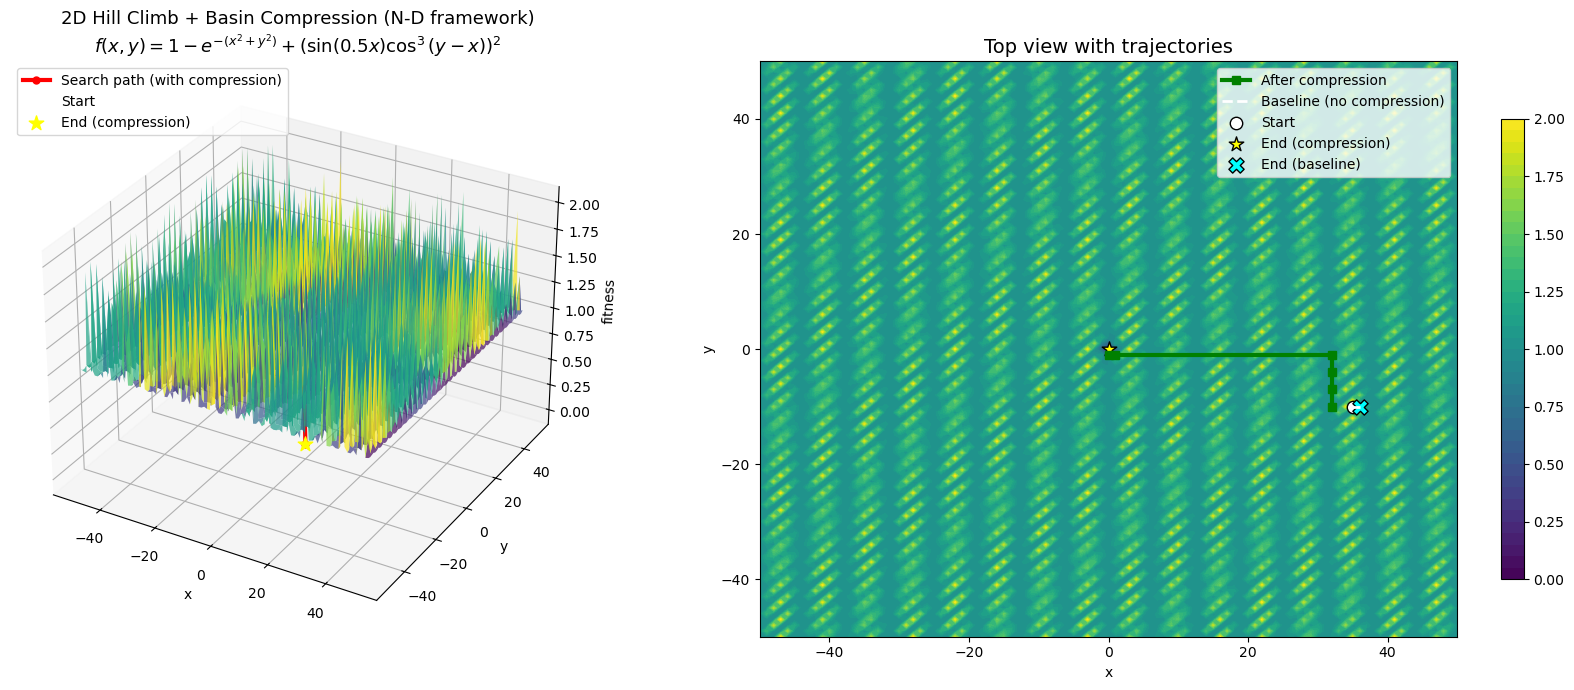

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# 1) 2D test function 정의
# ===============================
def f2d_complex(x, y):
    """
    f(x,y) = 1 - exp(-(x^2 + y^2)) + (sin(0.5*x) * cos^3(y - x))^2
    - 항상 >= 0
    - (0,0)이 global minimum (값 0)
    - 주변에 굴곡/로컬 미니마가 많은 landscape
    """
    x = float(x)
    y = float(y)

    r2 = x * x + y * y
    base = 1.0 - np.exp(-r2)
    osc  = np.sin(0.5 * x) * (np.cos(y - x) ** 3)
    return base + osc ** 2

# hill_climb_with_compression_nd가 요구하는 N-D 형태 래퍼
def f2d_complex_nd(point):
    x, y = point
    return f2d_complex(x, y)

# 시각화 / 탐색 도메인
X_MIN, X_MAX = -50, 50
Y_MIN, Y_MAX = -50, 50

# 시작점
START_2D = (35, -10)

print("Test function ready. Global min is at (0,0) with f=0.")
print(f"Start: {START_2D}, f={f2d_complex(*START_2D):.4f}")

# ===============================
# 2) Hill climb + basin compression 실행 (WITH compression)
# ===============================
traj2d, cm2d = hill_climb_with_compression_nd(
    fitness_func_nd=f2d_complex_nd,
    start_point=START_2D,
    dim=2,
    max_iterations=20,      # compression iteration 횟수
    basin_max_search=60,
    global_min_threshold=1e-6,
)

# traj2d 원소: (point, fitness, used_compression)
final_point, final_f, _ = traj2d[-1]
print(f"\n===== WITH COMPRESSION =====")
print(f"End:   {final_point}, f={final_f:.6g}")
print(f"Trajectory length: {len(traj2d)}")

# trajectory 분해 (N-D 형식에 맞게 언팩)
tx   = np.array([step[0][0] for step in traj2d], dtype=float)   # point[0] = x
ty   = np.array([step[0][1] for step in traj2d], dtype=float)   # point[1] = y
tf   = np.array([step[1]      for step in traj2d], dtype=float) # fitness
tcomp = np.array([step[2]     for step in traj2d], dtype=bool)  # True면 압축 사용 후 단계
idx_after  = np.where(tcomp)[0]   # compression 사용 후 단계 인덱스

# ===============================
# 2') Baseline hill climb 실행 (WITHOUT compression)
# ===============================
traj2d_base = hill_climb_simple_nd(
    fitness_func_nd=f2d_complex_nd,
    start_point=START_2D,
    dim=2,
    max_steps=2000
)

base_final_point, base_final_f = traj2d_base[-1]
print(f"\n===== BASELINE (NO COMPRESSION) =====")
print(f"End:   {base_final_point}, f={base_final_f:.6g}")
print(f"Trajectory length: {len(traj2d_base)}")

bx = np.array([p[0] for (p, f) in traj2d_base], dtype=float)
by = np.array([p[1] for (p, f) in traj2d_base], dtype=float)

# ===============================
# 3) Surface + path 시각화
# ===============================
x_grid = np.arange(X_MIN, X_MAX + 1, 1)
y_grid = np.arange(Y_MIN, Y_MAX + 1, 1)
X_vis, Y_vis = np.meshgrid(x_grid, y_grid)
Z_vis = np.zeros_like(X_vis, dtype=float)

for i in range(X_vis.shape[0]):
    for j in range(X_vis.shape[1]):
        Z_vis[i, j] = f2d_complex(X_vis[i, j], Y_vis[i, j])

fig = plt.figure(figsize=(18, 7))

# --- (1) 3D surface + path (compression 전체 경로는 그대로 빨강) ---
ax3d = fig.add_subplot(1, 2, 1, projection='3d')
ax3d.plot_surface(
    X_vis, Y_vis, Z_vis,
    cmap='viridis',
    alpha=0.7,
    linewidth=0,
    antialiased=True,
)
ax3d.plot(tx, ty, tf, 'r-o', linewidth=3, markersize=5, label='Search path (with compression)')

ax3d.scatter(tx[0], ty[0], tf[0], c='white', s=80, marker='o', label='Start')
ax3d.scatter(tx[-1], ty[-1], tf[-1], c='yellow', s=120, marker='*', label='End (compression)')

ax3d.set_title(
    "2D Hill Climb + Basin Compression (N-D framework)\n"
    r"$f(x,y)=1-e^{-(x^2+y^2)}+(\sin(0.5x)\cos^3(y-x))^2$",
    fontsize=13
)
ax3d.set_xlabel("x")
ax3d.set_ylabel("y")
ax3d.set_zlabel("fitness")
ax3d.legend(loc='upper left')

# --- (2) Contour + path (after compression + baseline) ---
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.contourf(X_vis, Y_vis, Z_vis, levels=40, cmap='viridis')
fig.colorbar(cs, ax=ax2, shrink=0.8)

# compression 사용 후 단계만 초록색
if len(idx_after) > 0:
    ax2.plot(
        tx[idx_after], ty[idx_after],
        'g-s',
        label='After compression',
        linewidth=3,
    )

# baseline: 흰색 점선
ax2.plot(
    bx, by,
    'w--',
    linewidth=2,
    label='Baseline (no compression)',
)

# start / end 마커
ax2.scatter(tx[0],  ty[0],
            c='white',  edgecolors='k', s=80,  marker='o', label='Start')
ax2.scatter(tx[-1], ty[-1],
            c='yellow', edgecolors='k', s=120, marker='*', label='End (compression)')
ax2.scatter(bx[-1], by[-1],
            c='cyan',   edgecolors='k', s=120, marker='X', label='End (baseline)')

ax2.set_title("Top view with trajectories", fontsize=14)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


🎨 FITNESS FUNCTION: Oscillating Plateau (bounded L/U)

Key points:
  x=-70 (left valley): 200.00
  x=-60 (plateau start): 132.00
  x=-30 (middle of plateau): 132.00
  x=0 (plateau middle): 132.00
  x=10 (plateau end): 132.00
  x=20 (right valley, GLOBAL MIN): 0.00

📊 Plateau statistics:
  Length: 71 points
  Local minima in plateau: 35
  Min fitness in plateau: 120.00
  Max fitness in plateau: 132.00


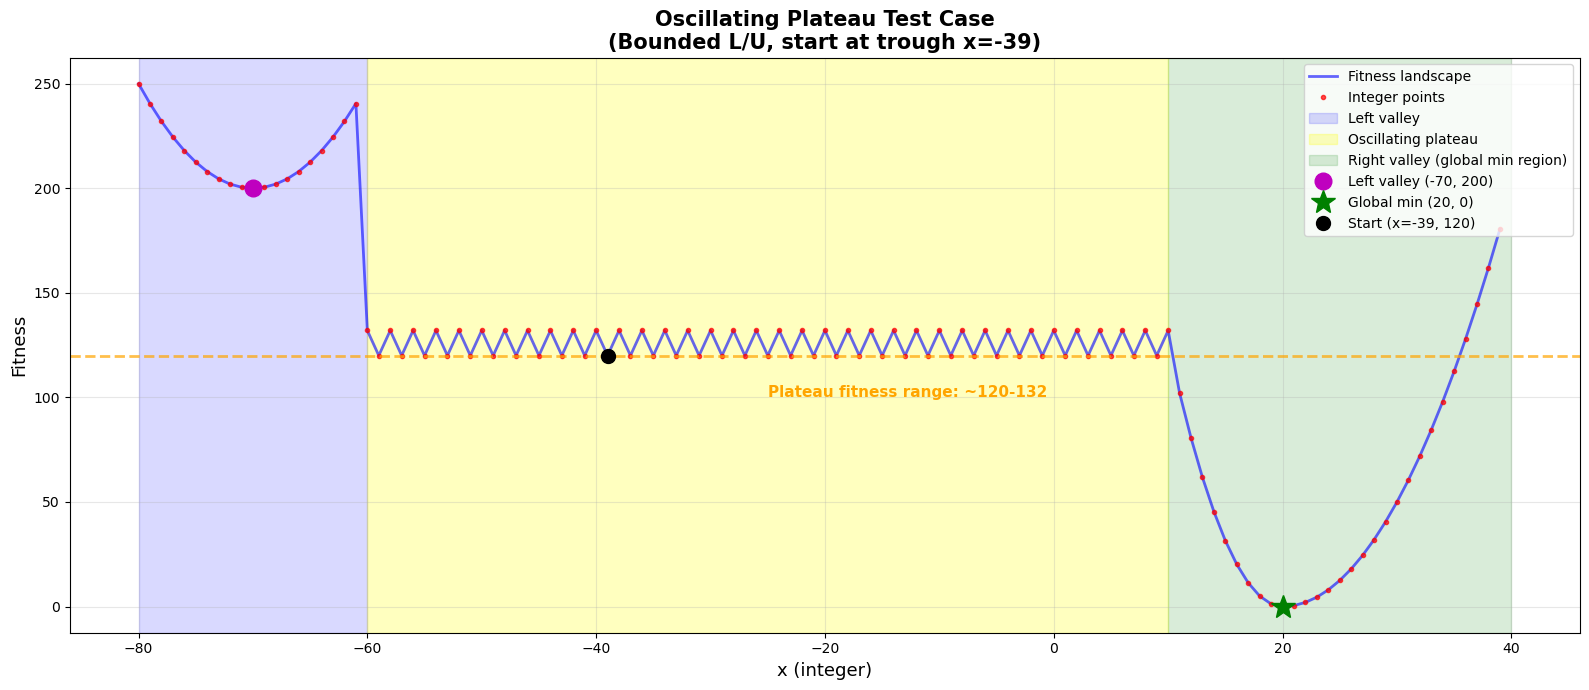


✅ Challenge: compress this 71-point plateau (with many local minima)

🚀 TEST (N-D framework, dim=1): Oscillating Plateau Compression

Starting at x=-39, fitness=120.00


🚀 1D hill climbing start at (-39,), f=120.0000

🔄 Iteration 1/10
  📍 Climbed 0 steps, now at (-39,), f=120

⚠️ STUCK at local minimum (-39,), f=120
  🔍 Detecting basins along all 1 dimensions...
  🔍 Detecting basin from local min: x=-39, fitness=120.00
    LEFT: x=-40, fitness=132.00 > 120.00 (plateau/hill)
    LEFT: x=-41, fitness=120.00 == 120.00 (continue)
    LEFT: x=-42, fitness=132.00 > 120.00 (plateau/hill)
    LEFT: x=-43, fitness=120.00 == 120.00 (continue)
    LEFT: x=-44, fitness=132.00 > 120.00 (plateau/hill)
    LEFT: x=-45, fitness=120.00 == 120.00 (continue)
    LEFT: x=-46, fitness=132.00 > 120.00 (plateau/hill)
    LEFT: x=-47, fitness=120.00 == 120.00 (continue)
    LEFT: x=-48, fitness=132.00 > 120.00 (plateau/hill)
    LEFT: x=-49, fitness=120.00 == 120.00 (continue)
    LEFT: x=-50, fitness=132.00

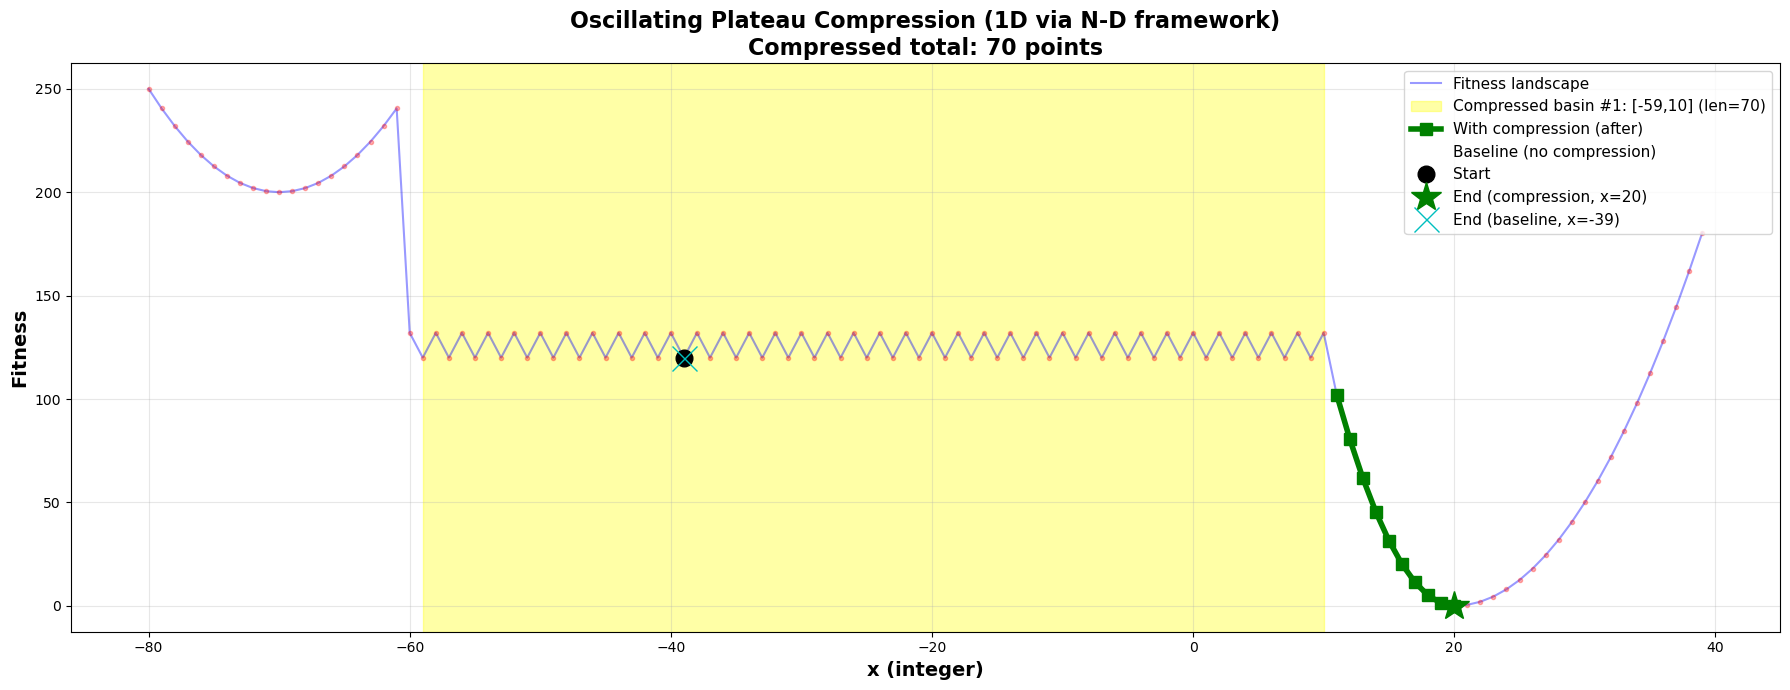

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1) Bounded oscillating plateau (1D fitness)
# -------------------------------
def fitness_oscillating_plateau_bounded(
    x,
    L=120.0, U=132.0,                 # 평탄부 하한/상한 (고정)
    plateau_left=-60, plateau_right=10,
    left_valley_center=-70, right_valley_center=20,
    trough_anchor=-39,                # 하한(L)이 정확히 나오게 할 기준 x (정수)
    alt_period=2                      # 교번 주기: 2면 L,U,L,U,...
):
    """
    - x < plateau_left      : 좌측 완만한 포물선(깊은 계곡)
    - plateau_left..right   : 정수 격자에서 정확히 L/U만 교번 (요철의 하/상한 고정)
                              (x - trough_anchor) % alt_period == 0 -> L, else U
    - plateau_right < x < rv: 전이 구간(우측 계곡으로 매끄럽게 하강; L보다 확실히 낮아짐)
    - x >= right_valley     : 우측 포물선(전역 최소)
    """
    x = int(x)

    if x < plateau_left:
        return 200.0 + 0.5 * (x - left_valley_center) ** 2

    if plateau_left <= x <= plateau_right:
        return L if ((x - trough_anchor) % alt_period) == 0 else U

    if plateau_right < x < right_valley_center:
        mid = 0.5 * (L + U)
        t = (x - plateau_right) / float(right_valley_center - plateau_right)  # 0→1
        return (mid * (1 - t) ** 2)  # 점점 내려가 L보다 확실히 낮아짐

    if x >= right_valley_center:
        return 0.5 * (x - right_valley_center) ** 2

    return 1e9  # safety

# 별칭
f1d = fitness_oscillating_plateau_bounded

# 파라미터
PL, PR = -60, 10
RV = 20
L, U = 120.0, 132.0
START_X = -39  # plateau 바닥(로컬 min으로 간주할 지점)

# -------------------------------
# 2) Plateau 통계 + Landscape 시각화
# -------------------------------
print("=" * 80)
print("🎨 FITNESS FUNCTION: Oscillating Plateau (bounded L/U)")
print("=" * 80)

print("\nKey points:")
print(f"  x=-70 (left valley): {f1d(-70):.2f}")
print(f"  x={PL} (plateau start): {f1d(PL):.2f}")
print(f"  x=-30 (middle of plateau): {f1d(-30):.2f}")
print(f"  x=0 (plateau middle): {f1d(0):.2f}")
print(f"  x={PR} (plateau end): {f1d(PR):.2f}")
print(f"  x={RV} (right valley, GLOBAL MIN): {f1d(RV):.2f}")

plateau_region = range(PL, PR + 1)
plateau_fitness = [f1d(x) for x in plateau_region]
local_minima_count = sum(
    1
    for i in range(1, len(plateau_fitness) - 1)
    if plateau_fitness[i] < plateau_fitness[i - 1]
    and plateau_fitness[i] < plateau_fitness[i + 1]
)
print(f"\n📊 Plateau statistics:")
print(f"  Length: {len(plateau_region)} points")
print(f"  Local minima in plateau: {local_minima_count}")
print(f"  Min fitness in plateau: {min(plateau_fitness):.2f}")
print(f"  Max fitness in plateau: {max(plateau_fitness):.2f}")

# 전체 landscape
x_viz = np.arange(-80, 40, 1)
y_viz = [f1d(x) for x in x_viz]

plt.figure(figsize=(16, 7))
plt.plot(x_viz, y_viz, 'b-', linewidth=2, alpha=0.6, label='Fitness landscape')
plt.plot(x_viz, y_viz, 'ro', markersize=3, label='Integer points', alpha=0.7)

plt.axvspan(-80, PL, alpha=0.15, color='blue', label='Left valley')
plt.axvspan(PL, PR, alpha=0.25, color='yellow', label='Oscillating plateau')
plt.axvspan(PR, 40, alpha=0.15, color='green', label='Right valley (global min region)')

plt.plot(-70, f1d(-70), 'mo', markersize=12, label=f'Left valley (-70, {f1d(-70):.0f})', zorder=10)
plt.plot(RV, f1d(RV), 'g*', markersize=18, label=f'Global min ({RV}, {f1d(RV):.0f})', zorder=10)
plt.plot(START_X, f1d(START_X), 'ko', markersize=10, label=f'Start (x={START_X}, {f1d(START_X):.0f})', zorder=10)

plt.axhline(y=min(plateau_fitness), color='orange', linestyle='--', linewidth=2, alpha=0.7)
plt.text(-25, min(plateau_fitness) - 20,
         f'Plateau fitness range: ~{min(plateau_fitness):.0f}-{max(plateau_fitness):.0f}',
         fontsize=11, color='orange', fontweight='bold')

plt.xlabel('x (integer)', fontsize=13)
plt.ylabel('Fitness', fontsize=13)
plt.title('Oscillating Plateau Test Case\n(Bounded L/U, start at trough x=-39)', fontsize=15, fontweight='bold')
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Challenge: compress this {len(plateau_region)}-point plateau (with many local minima)")
print("=" * 80)

# -------------------------------
# 3) N-D용 래퍼 (dim=1)
# -------------------------------
def f1d_nd(point):
    # point: (x,) 형태의 튜플/리스트
    x = point[0]
    return f1d(x)

# -------------------------------
# 4) WITH COMPRESSION (dim=1, N-D framework)
# -------------------------------
print("\n" + "=" * 80)
print("🚀 TEST (N-D framework, dim=1): Oscillating Plateau Compression")
print("=" * 80)
print(f"\nStarting at x={START_X}, fitness={f1d(START_X):.2f}\n")

traj1d, cm1d = hill_climb_with_compression_nd(
    fitness_func_nd=f1d_nd,
    start_point=(START_X,),  # 1D라서 튜플 하나
    dim=1,
    max_iterations=10,
    basin_max_search=100,
    global_min_threshold=1e-6,
)

final_point_nd, final_f_nd, _ = traj1d[-1]
final_x_nd = final_point_nd[0]

print(f"\n===== WITH COMPRESSION (dim=1 via N-D) =====")
print(f"  Started at: x={traj1d[0][0][0]}, f={traj1d[0][1]:.2f}")
print(f"  Ended at:   x={final_x_nd}, f={final_f_nd:.2f}")
print(f"  Total steps: {len(traj1d)}")

# CompressionManagerND에서 1D 압축 정보 뽑기
# dim=1 → vary_dim=0, fixed_coords=() (빈 튜플)
comps_1d = cm1d.dim_compressions[0].get((), [])
print(f"\n  Compressions found: {len(comps_1d)}")
for i, (start, length) in enumerate(comps_1d, 1):
    print(f"    #{i}: X[{start}, {start+length-1}] (length={length})")

# trajectory unpack
traj_x = np.array([step[0][0] for step in traj1d], dtype=int)
traj_y = np.array([step[1] for step in traj1d], dtype=float)
traj_used_comp = np.array([step[2] for step in traj1d], dtype=bool)
idx_after = np.where(traj_used_comp)[0]

# -------------------------------
# 5) BASELINE (without compression)
# -------------------------------
traj1d_base = hill_climb_simple_nd(
    fitness_func_nd=f1d_nd,
    start_point=(START_X,),
    dim=1,
    max_steps=2000
)

base_final_point, base_final_f = traj1d_base[-1]
base_final_x = base_final_point[0]

print(f"\n===== BASELINE (NO COMPRESSION) =====")
print(f"  Started at: x={traj1d_base[0][0][0]}, f={traj1d_base[0][1]:.2f}")
print(f"  Ended at:   x={base_final_x}, f={base_final_f:.2f}")
print(f"  Total steps: {len(traj1d_base)}")

base_x = np.array([p[0] for (p, f) in traj1d_base], dtype=int)
base_y = np.array([f for (p, f) in traj1d_base], dtype=float)

# -------------------------------
# 6) Visualize: path + compressed basins
# -------------------------------
fig, ax = plt.subplots(1, 1, figsize=(18, 7))

# landscape
ax.plot(x_viz, y_viz, 'b-', linewidth=1.5, alpha=0.4, label='Fitness landscape')
ax.plot(x_viz, y_viz, 'ro', markersize=3, alpha=0.3)

# 압축된 basin 표시 (노랑/주황 span) – 1D라서 훨씬 직관적
for i, (comp_start, comp_len) in enumerate(comps_1d, 1):
    comp_end = comp_start + comp_len - 1
    color = 'yellow' if comp_len > 30 else 'orange'
    ax.axvspan(comp_start, comp_end, alpha=0.35, color=color,
               label=f'Compressed basin #{i}: [{comp_start},{comp_end}] (len={comp_len})',
               zorder=1)

# compression 경로: "after compression"만 초록색
if len(idx_after) > 0:
    ax.plot(traj_x[idx_after], traj_y[idx_after],
            'g-', linewidth=4, marker='s', markersize=8,
            label='With compression (after)', zorder=5)

# baseline 경로: 흰색 점선
ax.plot(base_x, base_y,
        'w--', linewidth=2,
        label='Baseline (no compression)', zorder=4)

# 시작/끝 마커
ax.plot(traj_x[0], traj_y[0], 'ko', markersize=12, label='Start', zorder=10)
ax.plot(traj_x[-1], traj_y[-1], 'g*', markersize=22,
        label=f'End (compression, x={traj_x[-1]})', zorder=10)
ax.plot(base_x[-1], base_y[-1], 'cx', markersize=18,
        label=f'End (baseline, x={base_x[-1]})', zorder=10)

ax.set_xlabel('x (integer)', fontsize=14, fontweight='bold')
ax.set_ylabel('Fitness', fontsize=14, fontweight='bold')
title_extra = f"\nCompressed total: {sum(l for (_, l) in comps_1d)} points" if comps_1d else "\nNo basins compressed"
ax.set_title('Oscillating Plateau Compression (1D via N-D framework)' + title_extra,
             fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
